## Batch Peak Fit Program for dDAC Data

Authors: Biao Wang*, Christian Plückthun, Andrew Walker, Rachel Husband, Hauke Marquardt and Zuzana Konôpková

Biao Wang write the script and make the script able to do multi-peaks fit; Christian Plückthun and Zuzana Konôpková provide the initial version of the code; Andrew Walker and Rachel Husband help with the python and improve the code; Hauke Marquardt provide the support and guidance.

Thanks to all the people who helps to improve the code!

*email: biao.wang@earth.ox.ac.uk

Last update: 2021.02.28

### import libraries

In [1]:
# os is called  Miscellaneous operating system interfaces
# we need os here to manipulate paths of files
# os is a part of the standard library
# you will not need to download or install it separately from your Python installation
# but it is not a bulid in function, you have to import it when you want to use it 
import os
# golb is called Unix style pathname pattern expansion
# glob enable us to finds all the pathnames matching a specified pattern
# because we have several hundreds of files with similar names
# glob can hel us to find them with a simple command
from glob import glob
# progressbar can provide visual (yet text based) progress to long running operations.
# very useful if your are dealling with hundreds files
# it will let you know how long will the process finish and do you have enough time for a cup of coffee
# it will also let you know at which file, the progress failed (especially useful in peak fitting)
import progressbar
# NumPy is the fundamental package for scientific computing in Python. 
# it provides a multidimensional array object, various derived objects (such as masked arrays and matrices)
# and an assortment of routines for fast operations on arrays, including mathematical, 
# logical, shape manipulation, sorting, selecting, I/O, discrete Fourier transforms, basic linear algebra, 
# basic statistical operations, random simulation and much more.
import numpy as np
# pandas is a software library written for the Python programming language for data manipulation and analysis. 
# here we need it to import data from .xy or .pyfai files
import pandas as pd
# Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python.
# pyplot provides a MATLAB-like plotting framework.
import matplotlib.pyplot as plt
# cm is a builtin colormaps, colormap handling utilities, and the ScalarMappable mixin.
from matplotlib import cm
# specifies the geometry of the grid that a subplot will be placed
from matplotlib import gridspec
import bisect
from scipy.optimize import curve_fit

### bulid functions for further use

In [2]:
################################### Pesudo-Voigt for 1 peak fitting ################################################
# WavNr: Wave number, the x-axis over which shall be integrated
# Pos: Peak center position
# Amp: Amplitude of the peak
# GammaL: Gamma parameter of the Lorentzian distribution
# FracL: Fraction of Lorentzian distribution
def PesudoV_1(WavNr, Pos, Amp, GammaL, FracL):
    SigmaG = GammaL / np.sqrt(2*np.log(2)) # Calculate the sigma parameter for the Gaussian distribution(coupled in Pseudo-Voigt)
    LorentzPart = Amp / np.pi * (GammaL / ((WavNr - Pos)**2 + GammaL**2)) # Lorentzian distribution
    GaussPart = Amp / (np.sqrt(2*np.pi) * SigmaG) * np.exp( -(WavNr - Pos)**2 / (2 * SigmaG**2)) # Gaussian distribution
    Fit = FracL * LorentzPart + (1 - FracL) * GaussPart # Linear combination of the two parts
    return Fit
################################### Pesudo-Voigt for 2 peaks fitting ################################################# 
# a function of one Pesudo-Voigt + another Pesudo-Voigt
def PesudoV_2(WavNr, Pos1, Amp1, GammaL1, FracL1, Pos2, Amp2, GammaL2, FracL2 ):
    SigmaG1 = GammaL1 / np.sqrt(2*np.log(2))
    SigmaG2 = GammaL2 / np.sqrt(2*np.log(2))
    LorentzPart1 = Amp1 / np.pi * (GammaL1 / ((WavNr - Pos1)**2 + GammaL1**2))
    LorentzPart2 = Amp2 / np.pi * (GammaL2 / ((WavNr - Pos2)**2 + GammaL2**2)) 
    GaussPart1 = Amp1 / (np.sqrt(2*np.pi) * SigmaG1) * np.exp( -(WavNr - Pos1)**2 / (2 * SigmaG1**2))
    GaussPart2 = Amp2 / (np.sqrt(2*np.pi) * SigmaG2) * np.exp( -(WavNr - Pos2)**2 / (2 * SigmaG2**2))
    Fit = (FracL1 * LorentzPart1 + (1 - FracL1) * GaussPart1) + (FracL2 * LorentzPart2 + (1 - FracL2) * GaussPart2)
    return Fit

### load data from .xy files  to a defined variable in python

In [3]:
# data file have to be put in the same directory as the script or you need to modify the directory line
file_dir =glob(r'exampleData\HO2_L2_450K_m1_*.xy')
file_dir.sort()   # for mac and linux system
# number_files is the variable to contain the number of files in the .xy files' folder
# we need to know the number of files to define the loop to load data from .xy files
number_files = len(file_dir)
# we define an variable called df (data file or data frame if you like) to put all x-ray info from .xy files 
df = []
# start the progressbar before the loop to monitor the process
bar = progressbar.ProgressBar(maxval=(number_files)).start()
# i is an variable used in the loop to record loop info, we start from first file, therefore, i =1
i = 1
# start a loop in the files directory (the directory where we put all the .xy files)
# f is the name of file
# file_dir contain all the names of the .xy files
for f in file_dir:
    df.append(pd.read_csv(f, skiprows=[i for i in range(0,23)], header = None, sep = '\s+'))
    bar.update(i) 
    i = i +1

<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
C:\Users\wangb\AppData\Local\Temp\ipykernel_43556\4497480.py:17: SyntaxWarning: invalid escape sequence '\s'
  df.append(pd.read_csv(f, skiprows=[i for i in range(0,23)], header = None, sep = '\s+'))
100% |########################################################################|

In [4]:
# now, all the two-thetas and corresponding intensity info are stored in the variable
# we can use df to do the rest of the analysis, but it will make the programming looks ugly
# because we want to see the relation between two-thetas and intensities, it will make sence to 
# define two variables to put them seperately
twothetas = []
intensitys = []
# here we start a loop to tranfer the two-thetas info to the variable two-theta and intensities info to the variable intensitys
for i in range(1, number_files):
    twotheta = df[i].loc[0:4200,0].to_numpy()
    intensity = df[i].loc[0:4200,1].to_numpy() 
    twothetas.append(twotheta)
    intensitys.append(intensity)

### Check the details of data files before fitting

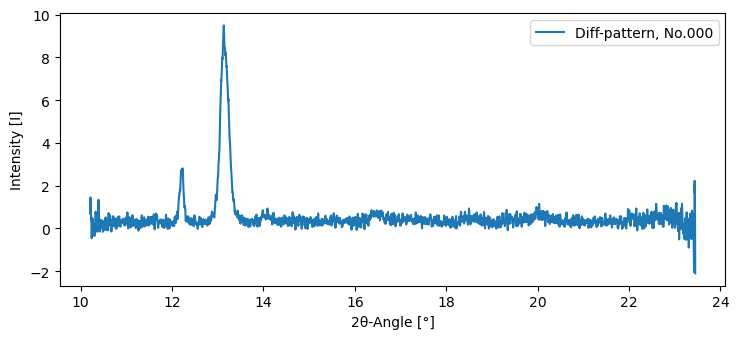

In [5]:
plt.close()
fig = plt.figure(figsize=(7.5, 3.5))
gs = gridspec.GridSpec(1,1)
ax0 = fig.add_subplot(gs[0])
'''You can change the file_num to check the file you need'''
file_num = 0
ax0.plot(twothetas[file_num], intensitys[file_num], color= 'C0', label='Diff-pattern, No.'+ str(file_num).zfill(3))
ax0.set_ylabel('Intensity [I]')
ax0.set_xlabel('2\u03B8-Angle [°]')
ax0.legend()
plt.tight_layout()

## 1 peak fitting (Pseudo-Voigt)

In [17]:
# Define some variables for fitting
# popts = p(parameter) + opts(optimization/fitting) = fitting parameters
# pcovs = p(parameter) + covs(covariance) = covariance of the fitting paramters
# this variable will contain the fitting parameters of all files
popts = []
# this variable will contain estimated covariance of the fitting paramters of all files
pcovs = []
# this variable will contain errors of the fitted parameters
perrs = []
'''Here you need to input your initial guess of the peak position and peak width'''
'''Adjust x（peak position）, r(peak width) and margins as initial guess'''
'''Also need to adjust the range of data in fit, suggest margin = 2'''
x = 12.21
r  = 0.1
margin = 2
# start the progressbar before the loop to monitor the process
bar = progressbar.ProgressBar(maxval=len(twothetas)).start()
# define lower and upper bounds for fitting parameters
lower = [0.0,  0.0,   1e-6,  0.0]
upper = [40.00,  np.inf, np.inf, 1.0]
# Loop for fitting all the files
# len(twotheta) gives the number of files
for i in range(0,len(twothetas)):
    # define a 2D matrices x=1, y=4 to store the fitting results
    popt = np.ndarray(shape=(1,4)) 
    # define a 3D matrices x=1, y=4 and z=4 to store the covariance of the fitting results
    pcov = np.ndarray(shape=(1, 4, 4))
    # define the range of two-theta in the fitting
    # x_start define the left limit
    # x_end define the right limit
    x_start = bisect.bisect(twothetas[i], x-margin*r)
    x_end = bisect.bisect(twothetas[i], x+margin*r)
    # p0 is the initial guess of the fitting
    # x is the guess peak position
    # np.max(intensitys[i][x_start:x_end]) is the guess of the peak intensity
    # r is the guess of the peak width
    # and 0.5 is the guess of the Fraction of Lorentzian distribution
    p0 = [x, np.max(intensitys[i][x_start:x_end]), r, 0.5]
    # start the fitting and put the fitting results in the popt and pcovs
    popt[0,:], pcov[0, :, :] = curve_fit(PesudoV_1, twothetas[i][x_start:x_end], 
                                         intensitys[i][x_start:x_end], p0, bounds=(lower, upper), method='trf')
    # store the results in popt and pcov in popts and pcovs
    pcovs.append(pcov)
    popts.append(popt)
    # 1-sigma parameter errors from covariance
    perr = np.sqrt(np.diag(pcov[0]))
    perrs.append(perr)
    # takes result from the last pattern to use as starting point for the next one
    x = float(popt[0, 0])
    r = float(popt[0, 2])
    bar.update(i)

 98% |####################################################################### |

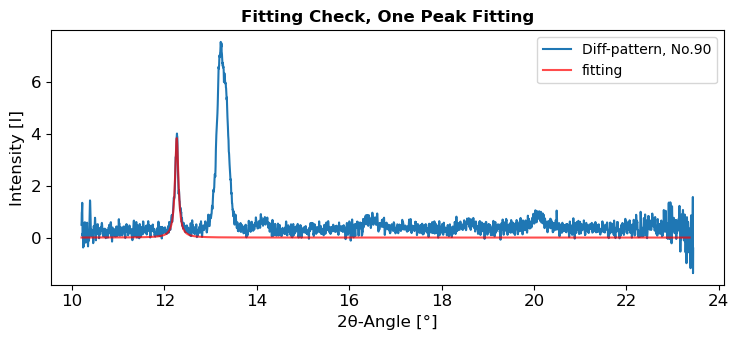

In [20]:
# Check 1 peak fitting results (Pseudo-Voigt)
plt.close()
plt.figure(figsize=(7.5, 3.5))
ax = plt.subplot(111)
file_num = 90
ax.plot(twothetas[file_num],intensitys[file_num], label='Diff-pattern, No.'+ str(file_num))
# for making a legend
ax.plot(15,0, linestyle='-', marker='', color='red', label='fitting', alpha=0.7)
# define an x range for caluclation of fitting results
xfit= np.linspace(twothetas[file_num][0], twothetas[file_num][4000], 4001) # adjust range based on feasable x0 range.
# calculate the fitting results
fitted = PesudoV_1(xfit, popts[file_num][0][0], popts[file_num][0][1], popts[file_num][0][2], popts[file_num][0][3])  
# plot the fitting results
ax.plot(xfit, fitted, color='red', alpha=0.7)
ax.legend()        
plt.ylabel('Intensity [I]', fontsize= 12)
plt.xlabel('2\u03B8-Angle [°]', fontsize= 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Fitting Check, One Peak Fitting', fontsize=12, fontweight='bold')
plt.tight_layout()

In [19]:
results = np.array(popts).reshape((len(popts), 4))
errors  = np.array(perrs).reshape((len(perrs), 4))

out = np.hstack([results, errors])

np.savetxt(
    "1_PeakFit_with_errors.csv",
    out,
    delimiter=",",
    header="Pos,Amp,GammaL,FracL,Pos_err,Amp_err,GammaL_err,FracL_err",
    comments=""
)

os.startfile("1_PeakFit_with_errors.csv")


## 2 peaks fitting (Pseudo-Voigt)

In [13]:
popts = [] 
pcovs = [] 
"""Here you need to input your initial guess of the peak position and peak width"""
"""Adjust x（peak position）, r(peak width) and margins as initial guess"""
x_1 = 12.21
x_2 = 13.15
r_1  = 0.1
r_2  = 0.1
margin_1 = 2
margin_2 = 2

bar = progressbar.ProgressBar(maxval=len(twothetas)).start()

for i in range(0,len(twothetas)):
    popt = np.ndarray(shape=(1, 8), dtype=object)
    pcov = np.ndarray(shape=(1, 8, 8), dtype=object)
    x_start1 = bisect.bisect(twothetas[i],x_1-margin_1*r_1)
    x_end1 = bisect.bisect(twothetas[i],x_1+margin_1*r_1)
    x_start2 = bisect.bisect(twothetas[i],x_2-margin_2*r_2)
    x_end2 = bisect.bisect(twothetas[i],x_2+margin_2*r_2)
    p0 = [x_1, np.max(intensitys[i][x_start1:x_end1]), r_1, 0.5, x_2, np.max(intensitys[i][x_start2:x_end2]), r_2, 0.5]
    popt[0,:], pcov[0, :, :] = curve_fit(PesudoV_2, twothetas[i][x_start1:x_end2], intensitys[i][x_start1:x_end2], p0, method='trf')
    pcovs.append(pcov)
    popts.append(popt)
    x_1 = float(popt[0, 0])
    r_1 = float(popt[0, 2])
    x_2 = float(popt[0, 4])
    r_2 = float(popt[0, 6])
    bar.update(i)

 98% |####################################################################### |

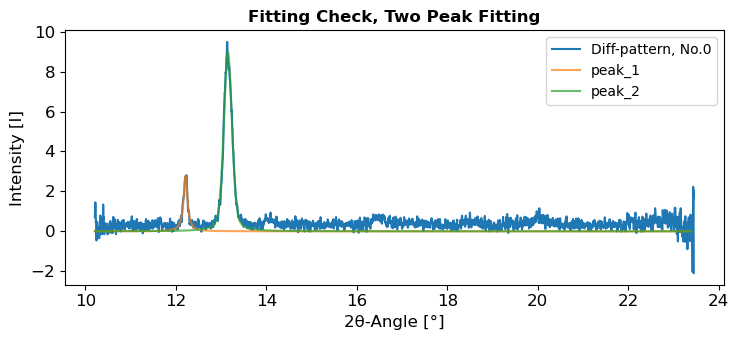

In [14]:
# Check 2 peaks fitting results (Pseudo-Voigt)
plt.close()
plt.figure(figsize=(7.5,3.5))
ax = plt.subplot(111)
file_num = 0
ax.plot(twothetas[file_num],intensitys[file_num], label='Diff-pattern, No.'+ str(file_num))
ax.plot(14,0, linestyle='-', marker='', color='C1', label='peak_1', alpha=0.7)
ax.plot(14,0, linestyle='-', marker='', color='C2', label='peak_2', alpha=0.7)
xfit= np.linspace(twothetas[file_num][0], twothetas[file_num][4000], 4001)
fitted_1 = PesudoV_1(xfit, popts[file_num][0][0], popts[file_num][0][1], popts[file_num][0][2], popts[file_num][0][3]) 
fitted_2 = PesudoV_1(xfit, popts[file_num][0][4], popts[file_num][0][5], popts[file_num][0][6], popts[file_num][0][7]) 
ax.plot(xfit, fitted_1, color='C1', alpha=0.7)
ax.plot(xfit, fitted_2, color='C2', alpha=0.7)
ax.legend()        
plt.ylabel('Intensity [I]', fontsize= 12)
plt.xlabel('2\u03B8-Angle [°]', fontsize= 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Fitting Check, Two Peak Fitting', fontsize=12, fontweight='bold')
plt.tight_layout()

In [11]:
# save the fitting results to .csv file and open it
results = np.array(popts).reshape((len(popts), 8))
np.savetxt('2_PeakFit.csv', results, delimiter=',', header="Pos1, Amp1, GammaL1, FracL1, Pos2, Amp2, GammaL2, FracL2")
os.startfile('2_PeakFit.csv')